# 深度学习基础

## 3.1线性回归

解析解：可以算出来的精确解
数值解：通过最优化算法算出来的解

batch：为了保证电脑不炸而使用的数据切分，所以在电脑能承受的情况下把所有数据全部作为1个batch是最好的
比如有2000个数据我拆成4个batch每组500数据，500就称为batch_size  
  
  
iteration：迭代，1个batch丢进去进行1次梯度下降更新称为1次迭代
那么为了全部训练，就会进行4次iteration，进行完后整个数据就进行了一次梯度下降算法，这就称为1个epoch  
  
  
epoch：所有数据都进行了1次迭代称为1次epoch，即1个时期（纪元）  
然后进行成百上千次epoch直到结果收敛，就得到了训练结果

## 3.2线性回归从零实现

In [1]:
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
# 输入特征数为2，此处是房子模型，用房龄和面积确定房子的价格
num_inputs = 2
# 随机生成1000个例子
num_examples = 1000

# 真实的w和b
# 即真正的表达式为y = 2 * x1 - 3.4 * x2 + 4.2
true_w = [2, -3.4]
true_b = 4.2

# 随机生成数据
# features是1000*2的Tensor，数据类型是float
features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
# labels是带入了真实的表达式算出了真实的结果
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 在每个labels上加上了均值为0，标准差为0.01的正态分布的值，相当于加入了一个噪声
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

# 上述程序干了如下几件事：
# 1. 定义了真实的表达式
# 2. 随机生成了1000个x，并使用真实的表达式算出了标准的y
# 3. 给标准的y加上了一些噪声，使得每个y有些许偏移。这样就得到了代表采集到的数据x和y，也就是训练集
# 现在要做如下事情：
# 根据加了噪声的已有数据进行回归运算来猜出w和b，并与真实的w和b进行比对

# 结果看看
print(features[0], labels[0])

tensor([-2.0886, -1.0477]) tensor(3.5831)


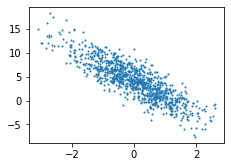

In [3]:
def use_svg_display():
    pass
    # 用矢量图显示，目前此句暂时无法运行
    # display.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize


# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import *

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # random.shuffle的意思是将indices输入并shuffle（洗牌）然后再赋值回给indices，也就是说现在indices是乱的
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        # i从0开始，每次+=batch_size
        # 把那一batch_size组tensor化，命名为j
        # indices[i:最后一位]，冒号代表索引的基本操作
        # 因为最后一次可能不足一个batch，所以最后一组的尾部由i + batch_size, num_examples中的最小决定
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        # index_select见上节pytorch索引，三个参数为开始结束和步长
        yield features.index_select(0, j), labels.index_select(0, j)


batch_size = 10

# 打印出10组数据看看
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.9831,  0.7696],
        [-0.7998,  1.1627],
        [-0.4431, -0.5531],
        [-1.4065, -0.7737],
        [-0.9541,  1.7075],
        [-0.2739,  0.3848],
        [-0.4480,  1.2105],
        [-0.1386, -0.0757],
        [ 0.5238, -1.3986],
        [ 0.2828,  0.1796]]) tensor([ 3.5514, -1.3554,  5.1872,  4.0148, -3.5158,  2.3531, -0.8091,  4.1717,
         9.9871,  4.1458])


In [5]:
# 将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# 添加跟踪
w.requires_grad_(True)
b.requires_grad_(True)


# 结果表达式
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b


# 损失函数
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2


# 优化算法
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size  # 注意这里更改param时用的param.data


# 开始训练模型
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.034650
epoch 2, loss 0.000123
epoch 3, loss 0.000051


In [6]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0003],
        [-3.4002]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)
